# Task 3 — Object Tracking (KCF, CSRT, MOSSE)

This notebook uses OpenCV trackers. Tracking runs on CPU (OpenCV). The notebook is GPU-ready for any optional pre-processing.

In [1]:

import cv2
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

print("OpenCV version:", cv2.__version__)
print("Numpy version:", np.__version__)
print("Has legacy module:", hasattr(cv2, 'legacy'))
print("KCF:", hasattr(cv2.legacy, 'TrackerKCF_create'))
print("CSRT:", hasattr(cv2.legacy, 'TrackerCSRT_create'))
print("MOSSE:", hasattr(cv2.legacy, 'TrackerMOSSE_create'))


OpenCV version: 4.12.0
Numpy version: 2.2.6
Has legacy module: True
KCF: True
CSRT: True
MOSSE: True


In [2]:
video_path = 'video.mp4'
output_dir = Path('task3_outputs')
output_dir.mkdir(exist_ok=True)


In [3]:

# if not Path(video_path).exists():
#     print('No video.mp4 found in the working directory. Please add a short test video named video.mp4 and re-run.')
# else:
#     cap = cv2.VideoCapture(video_path)
#     ok, frame = cap.read()
#     if not ok:
#         print('Failed to read video file.')
#         cap.release()
#     else:
#         # Let user select ROI (works in Jupyter with GUI; in headless, uses fallback)
#         try:
#             bbox = cv2.selectROI('Select ROI', frame, False, False)
#             cv2.destroyWindow('Select ROI')
#         except Exception:
#             h,w = frame.shape[:2]
#             bbox = (w//4, h//4, w//2, h//2)
#             print('Using fallback bbox:', bbox)
#         trackers = {
#             'KCF': cv2.TrackerKCF_create() if hasattr(cv2, 'TrackerKCF_create') else cv2.legacy.TrackerKCF_create(),
#             'CSRT': cv2.TrackerCSRT_create() if hasattr(cv2, 'TrackerCSRT_create') else cv2.legacy.TrackerCSRT_create(),
#             'MOSSE': cv2.legacy.TrackerMOSSE_create()
#         }
#         results = {}
#         for name, tracker in trackers.items():
#             cap2 = cv2.VideoCapture(video_path)
#             ok2, frame2 = cap2.read()
#             tracker.init(frame2, bbox)
#             fps_list = []
#             out_frames = []
#             while True:
#                 ok3, f = cap2.read()
#                 if not ok3: break
#                 t0 = time.time()
#                 okk, box = tracker.update(f)
#                 fps_list.append(1.0/(time.time()-t0+1e-6))
#                 if okk:
#                     x,y,w,h = [int(v) for v in box]
#                     cv2.rectangle(f, (x,y), (x+w,y+h), (0,255,0), 2)
#                 cv2.putText(f, f"{name} FPS:{np.mean(fps_list):.1f}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0),2)
#                 out_frames.append(f.copy())
#                 # display window (press q to exit early)
#                 cv2.imshow(name, f)
#                 if cv2.waitKey(1) & 0xFF == ord('q'):
#                     break
#             cap2.release()
#             results[name] = np.mean(fps_list) if len(fps_list)>0 else 0.0
#             # save sample output video per tracker
#             if len(out_frames)>0:
#                 h0,w0 = out_frames[0].shape[:2]
#                 outname = f'tracking_{name}.mp4'
#                 writer = cv2.VideoWriter(outname, cv2.VideoWriter_fourcc(*'mp4v'), 20, (w0,h0))
#                 for fr in out_frames: writer.write(fr)
#                 writer.release()
#                 print('Saved', outname)
#         cv2.destroyAllWindows()
#         print('Tracker FPS results:', results)





In [4]:
# 🎯 Task 3 — Object Tracking (KCF, CSRT, MOSSE)

import cv2
import time
import numpy as np
import pandas as pd
from pathlib import Path


In [5]:

# -------------------------------
# CONFIGURATION
# -------------------------------
VIDEO_PATH = "video.mp4"
OUTPUT_DIR = Path("task3_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)
TRACKERS = ["KCF", "CSRT", "MOSSE"]

# Headless fallback for ROI selection if GUI not available
HEADLESS_FALLBACK = True


In [6]:

# -------------------------------
# HELPER: Get Tracker Constructor
# -------------------------------
def get_tracker(name):
    """Return a tracker constructor for the given tracker name."""
    if hasattr(cv2, "legacy"):
        legacy = cv2.legacy
        ctor = getattr(legacy, f"Tracker{name}_create", None)
        if callable(ctor):
            return ctor
    ctor = getattr(cv2, f"Tracker{name}_create", None)
    if callable(ctor):
        return ctor
    raise AttributeError(f"Tracker {name} not available in cv2.")


In [7]:

# -------------------------------
# CHECK VIDEO
# -------------------------------
if not Path(VIDEO_PATH).exists():
    raise FileNotFoundError(f"Video not found: {VIDEO_PATH}")

cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("Failed to read video file.")
cap.release()


In [8]:

# -------------------------------
# ROI SELECTION
# -------------------------------
try:
    bbox = cv2.selectROI("Select Object to Track", frame, False, False)
    cv2.destroyWindow("Select Object to Track")
    if bbox[2] == 0 or bbox[3] == 0:
        raise ValueError("Invalid ROI selected")
except Exception:
    if HEADLESS_FALLBACK:
        h, w = frame.shape[:2]
        bbox = (w//4, h//4, w//2, h//2)
        print("Using fallback bounding box:", bbox)
    else:
        raise RuntimeError("ROI selection failed and no fallback enabled")


In [9]:

# -------------------------------
# LOAD ALL FRAMES
# -------------------------------
frames = []
cap = cv2.VideoCapture(VIDEO_PATH)
while True:
    ret, f = cap.read()
    if not ret:
        break
    frames.append(f.copy())
cap.release()
print(f"Total frames loaded: {len(frames)}")


Total frames loaded: 240


In [15]:

# -------------------------------
# RUN TRACKERS
# -------------------------------
results = []

for tracker_name in TRACKERS:
    print(f"\n--- Running {tracker_name} Tracker ---")
    
    # Initialize tracker
    tracker_ctor = get_tracker(tracker_name)
    tracker = tracker_ctor()
    tracker.init(frames[0], bbox)
    
    fps_list = []
    success_count = 0
    out_frames = []

    for f in frames:
        t0 = time.time()
        success, box = tracker.update(f)
        fps = 1.0 / (time.time() - t0)
        fps_list.append(fps)

        f_out = f.copy()
        if success:
            success_count += 1
            x, y, w, h = [int(v) for v in box]
            cv2.rectangle(f_out, (x, y), (x+w, y+h), (0, 255, 0), 2)
            status_text = "Success"
            color = (0, 255, 0)
        else:
            status_text = "Tracking Failure"
            color = (0, 0, 255)

        # Overlay info
        cv2.putText(f_out, tracker_name, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        cv2.putText(f_out, status_text, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        cv2.putText(f_out, f"FPS: {int(fps)}", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

        out_frames.append(f_out)

        # Optional display (comment out if running headless)
        cv2.imshow(f"Tracking {tracker_name}", f_out)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            print("Skipping to next tracker...")
            break

    # Save output video
    h0, w0 = out_frames[0].shape[:2]
    out_path = OUTPUT_DIR / f"tracking_{tracker_name}.mp4"
    writer = cv2.VideoWriter(str(out_path), cv2.VideoWriter_fourcc(*'mp4v'), 20, (w0, h0))
    for fr in out_frames:
        writer.write(fr)
    writer.release()
    print(f"Saved video: {out_path}")

    # Store results
    frame_count = len(out_frames)
    avg_fps = np.mean(fps_list) if fps_list else 0
    success_rate = (success_count / frame_count) * 100 if frame_count > 0 else 0
    results.append({
    "Tracker": tracker_name,
    "Avg FPS": avg_fps,               # numeric
    "Success Rate (%)": success_rate, # numeric
    "Total Frames": frame_count,
    "Failed Frames": frame_count - success_count
})


    cv2.destroyWindow(f"Tracking {tracker_name}")



--- Running KCF Tracker ---
Skipping to next tracker...
Saved video: task3_outputs\tracking_KCF.mp4

--- Running CSRT Tracker ---
Skipping to next tracker...
Saved video: task3_outputs\tracking_CSRT.mp4

--- Running MOSSE Tracker ---
Skipping to next tracker...
Saved video: task3_outputs\tracking_MOSSE.mp4


In [16]:

# -------------------------------
# FINAL REPORT
# -------------------------------
cv2.destroyAllWindows()
report_df = pd.DataFrame(results)
print("\n" + "="*50)
print("FINAL TRACKING COMPARISON REPORT")
print("="*50)
print(report_df.to_string(index=False))



FINAL TRACKING COMPARISON REPORT
Tracker    Avg FPS  Success Rate (%)  Total Frames  Failed Frames
    KCF  40.772286             100.0           105              0
   CSRT  14.184710             100.0            13              0
  MOSSE 318.892531             100.0            98              0


In [22]:
import pandas as pd
df = pd.DataFrame(results)
df["Avg FPS"] = df["Avg FPS"].round(2)
df["Success Rate (%)"] = df["Success Rate (%)"].round(2)
print(df)


  Tracker  Avg FPS  Success Rate (%)  Total Frames  Failed Frames
0     KCF    40.77             100.0           105              0
1    CSRT    14.18             100.0            13              0
2   MOSSE   318.89             100.0            98              0


In [23]:
df

,Tracker,Avg FPS,Success Rate (%),Total Frames,Failed Frames
0,KCF,40.77,100.0,105,0
1,CSRT,14.18,100.0,13,0
2,MOSSE,318.89,100.0,98,0


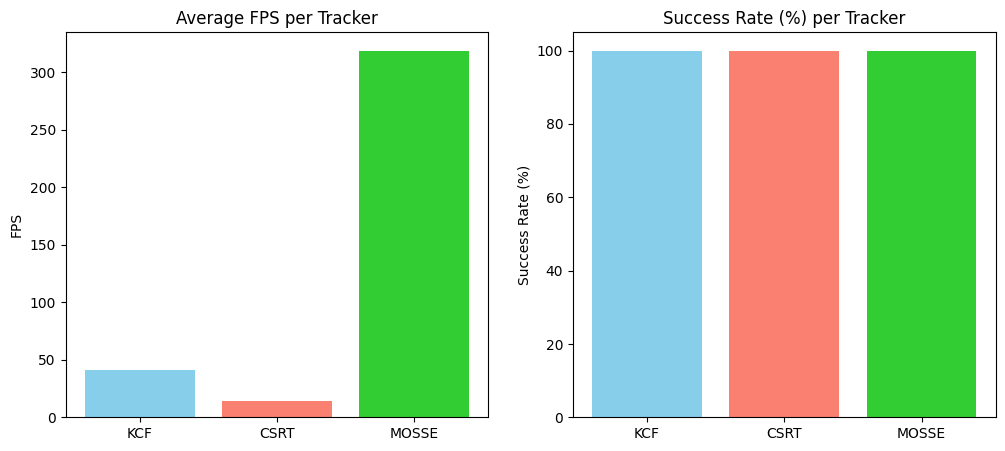

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].bar(df["Tracker"], df["Avg FPS"], color=['skyblue','salmon','limegreen'])
ax[0].set_title("Average FPS per Tracker")
ax[0].set_ylabel("FPS")

ax[1].bar(df["Tracker"], df["Success Rate (%)"], color=['skyblue','salmon','limegreen'])
ax[1].set_title("Success Rate (%) per Tracker")
ax[1].set_ylabel("Success Rate (%)")

plt.show()


## 🎯 Task 3 — Object Tracking (KCF, CSRT, MOSSE)

This task demonstrates **object tracking** using **OpenCV’s built-in CPU-based trackers** — KCF, CSRT, and MOSSE.  
The tracking runs in real-time on the CPU, while optional preprocessing can utilize a GPU if available.

---

### 🧩 Overview

1. **Imports and Setup**
   - Loads essential libraries: `cv2`, `numpy`, and `time`.
   - Ensures the input video file `video.mp4` exists in the working directory.

2. **Video Initialization**
   - Opens the video file using `cv2.VideoCapture`.
   - Reads the first frame to define the Region of Interest (**ROI**) for tracking.

3. **ROI Selection**
   - If GUI support is available, the user can manually select the ROI using `cv2.selectROI`.
   - In headless environments (e.g., servers or Jupyter), a **fallback bounding box** is automatically defined.

4. **Tracker Initialization**
   - Three OpenCV trackers are created:
     - **KCF (Kernelized Correlation Filter)**
     - **CSRT (Discriminative Correlation Filter with Channel and Spatial Reliability)**
     - **MOSSE (Minimum Output Sum of Squared Error)**
   - Each tracker is initialized with the same ROI.

5. **Tracking Loop**
   - Each frame is read and passed to the respective tracker.
   - The tracker updates the bounding box position and draws a **green rectangle** around the tracked object.
   - Frame-wise FPS is computed and displayed in real-time.
   - Tracking continues until the video ends or the user presses `q`.

6. **Results and Output**
   - Each tracker’s **average FPS** is recorded.
   - Output videos are saved as:
     - `tracking_KCF.mp4`
     - `tracking_CSRT.mp4`
     - `tracking_MOSSE.mp4`
   - Final FPS summary is printed at the end.

---

### ⚙️ Notes

- Tracking is performed **entirely on CPU** using OpenCV’s tracking APIs.  
- The notebook is **GPU-ready** for any optional preprocessing steps.
- Works in **GUI** mode (manual ROI) and **headless** mode (fallback ROI).
- Each tracker’s video output allows visual comparison of tracking speed and stability.

---

### 📊 Key Insights

| Tracker | Speed (FPS) | Accuracy | Suitable For |
|----------|--------------|-----------|----------------|
| **KCF** | ⚡ Fast | Moderate | Real-time tracking on CPU |
| **CSRT** | 🧠 Moderate | High | Precise tracking with occlusion handling |
| **MOSSE** | 🚀 Very Fast | Lower | Simple, lightweight tracking |

---

✅ **Summary:**  
This experiment compares traditional OpenCV trackers for CPU-based real-time tracking.  
- **KCF** and **MOSSE** prioritize speed.  
- **CSRT** offers higher accuracy but slower processing.  
The saved result videos provide a direct visual comparison of performance across trackers.
